In [179]:
import numpy as np
import re
import random

In [180]:
random.seed(30)

In [181]:
def tokenize(text):
    # obtains tokens with a least 1 alphabet
    pattern = re.compile(r'[A-Za-z]+[\w^\']*|[\w^\']*[A-Za-z]+[\w^\']*')
    return pattern.findall(text.lower())

In [182]:
def mapping(tokens):
    word_to_id = dict()
    id_to_word = dict()
    for i,word in enumerate(set(tokens)):
        word_to_id[word] = i
        id_to_word[i] = word
    return word_to_id, id_to_word

In [183]:
doc = "After the deduction of the costs of investing, " \
      "beating the stock market is a loser's game."
tokens = tokenize(doc)
print(tokens)

['after', 'the', 'deduction', 'of', 'the', 'costs', 'of', 'investing', 'beating', 'the', 'stock', 'market', 'is', 'a', "loser's", 'game']


In [184]:
word_to_id, id_to_word = mapping(tokens)
print(set(tokens))
print(id_to_word[0])

{'the', 'market', 'beating', 'deduction', 'after', 'stock', 'a', "loser's", 'is', 'investing', 'game', 'costs', 'of'}
the


In [185]:
#under stand code
# def generate_training_date(tokens, id_to_word, window_size):
#     L = len(tokens)
#     X, Y = [], []
#     for i in range(L):
#         index_before_after = list(range(max(0,i-window_size,i))) + list(range(i+1, min(i+window_size+1,L)))
#         for j in index_before_after:
#             X.append(id_to_word[i])
#             Y.append(id_to_word[j])
#     return X,Y

In [186]:
#X,Y = generate_training_date(tokens, id_to_word, 3)

In [187]:
#print(X[:10])
#print("------------------------------------------------------")
#print(Y[:10])

In [188]:
#real code
def generate_training_date(tokens, word_to_id, window_size):
    L = len(tokens)
    X, Y = [], []
    for i in range(L):
        index_before_after = list(range(max(0, i - window_size), i)) + \
                             list(range(i + 1, min(i + window_size + 1,L)))
        #print(index_before_after)
        for j in index_before_after:
            X.append(word_to_id[tokens[i]])
            Y.append(word_to_id[tokens[j]])
    X = np.array(X)
    X = np.expand_dims(X, axis=0)
    Y = np.array(Y)
    Y = np.expand_dims(Y, axis=0)       
    return X,Y

In [189]:
X,Y = generate_training_date(tokens, word_to_id, 3)
print(X.shape)
print(Y.shape)

(1, 84)
(1, 84)


In [190]:
vocab_size = len(id_to_word)
m = Y.shape[1]
Y_one_hot = np.zeros((vocab_size,m))
Y_one_hot[Y.flatten(), np.arange(m)] = 1
#Y_one_hot[84 cua y flatten, 0 -> 84]
print(Y.shape)
print(Y_one_hot.shape)
print(Y_one_hot[:,1])

(1, 84)
(13, 84)
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [206]:
def initialize_wrd_ebd(vocab_size, embed_size):
    random.seed(30)
    return np.random.randn(vocab_size, embed_size) * 0.01

def initialize_dense(input_size, output_size):
    random.seed(30)
    return np.random.randn(input_size,output_size) * 0.01

def initialize_parameters(vocab_size, embed_size):
    embedded_layer = initialize_wrd_ebd(vocab_size, embed_size)
    dense_layer = initialize_dense(vocab_size, embed_size)
    
    parameters = {}
    parameters['emb'] = embedded_layer
    parameters['W'] = dense_layer
    return parameters
    

In [207]:
def input_to_word_vecs(X, parameters):
    m = X.shape[1]
    embeded_matrix = parameters['emb']
    # X shape (1, 84)
    # embeded_matrix (13, 50)
    word_vectors = embeded_matrix[X.flatten(),:].T
    return word_vectors
    #print(word_vectors.shape) 50 84

In [208]:
#parameters = initialize_parameter(vocab_size, 50)
#word_vectors = input_to_word_vecs(X,parameters)

In [209]:
def linear_dense(word_vectors, parameters):
    W = parameters['W']
    #print(W.shape) 13 50
    Z = np.dot(W, word_vectors)
    #print(Z.shape) 13 84
    return W, Z

In [210]:
#linear_dense(word_vectors, parameters)

In [211]:
def softmax(Z):
    """
    Z: output out of the dense layer. shape: (vocab_size, m)
    """
    softmax_out = np.divide(np.exp(Z), np.sum(np.exp(Z), axis=0, keepdims=True) + 0.001)
    assert(softmax_out.shape == Z.shape)

    return softmax_out

In [212]:
def foward_prop(X, parameters):
    word_vectors = input_to_word_vecs(X, parameters)
    W, Z = linear_dense(word_vectors, parameters)
    softmax_out = softmax(Z)
    
    caches = {}
    caches['X'] = X
    caches['word_vec'] = word_vectors
    caches['W'] = W
    caches['Z'] = Z
    return softmax_out, caches

In [221]:
paramaters = initialize_parameters(vocab_size, 50)
softmax_out, caches = foward_prop(X, paramaters)

In [229]:
def cross_entropy(softmax_out, Y):
    """
    softmax_out: output out of softmax. shape: (vocab_size, m)
    """
    m = softmax_out.shape[1]
    cost = -(1 / m) * np.sum(np.log(softmax_out[Y.flatten(), np.arange(Y.shape[1])] + 0.001))
    return cost
def softmax_backward(Y, softmax_out):
    """
    Y: labels of training data. shape: (vocab_size, m)
    softmax_out: output out of softmax. shape: (vocab_size, m)
    """
    m = Y.shape[1]
    softmax_out[Y.flatten(), np.arange(m)] -= 1.0
    dL_dZ = softmax_out
    
    assert(dL_dZ.shape == softmax_out.shape)
    return dL_dZ

def dense_backward(dL_dZ, caches):
    """
    dL_dZ: shape: (vocab_size, m)
    caches: dict. results from each steps of forward propagation
    """
    W = caches['W']
    word_vec = caches['word_vec']
    m = word_vec.shape[1]
    
    dL_dW = (1 / m) * np.dot(dL_dZ, word_vec.T)
    dL_dword_vec = np.dot(W.T, dL_dZ)

    assert(W.shape == dL_dW.shape)
    assert(word_vec.shape == dL_dword_vec.shape)
    
    return dL_dW, dL_dword_vec

def backward_propagation(Y, softmax_out, caches):
    dL_dZ = softmax_backward(Y, softmax_out)
    dL_dW, dL_dword_vec = dense_backward(dL_dZ, caches)
    
    gradients = dict()
    gradients['dL_dZ'] = dL_dZ
    gradients['dL_dW'] = dL_dW
    gradients['dL_dword_vec'] = dL_dword_vec
    
    return gradients

def update_parameters(parameters, caches, gradients, learning_rate):
    vocab_size, emb_size = parameters['emb'].shape
    inds = caches['X']
    dL_dword_vec = gradients['dL_dword_vec']
    m = inds.shape[-1]
    
    parameters['emb'][inds.flatten(), :] -= dL_dword_vec.T * learning_rate

    parameters['W'] -= learning_rate * gradients['dL_dW']
from datetime import datetime

import matplotlib.pyplot as plt


def skipgram_model_training(X, Y, vocab_size, emb_size, learning_rate, epochs, batch_size=256, parameters=None, print_cost=False, plot_cost=True):
    costs = []
    m = X.shape[1]
    
    
    print(X)
    print(X.shape)
    print(Y)
    print(Y.shape)
    print("__________________________")
    
    
    if parameters is None:
        parameters = initialize_parameters(vocab_size, emb_size)
        #print(parameters['WRD_EMB'].shape)
        #print(parameters['W'].shape)
    
    begin_time = datetime.now()
    for epoch in range(epochs):
        epoch_cost = 0
        batch_inds = list(range(0, m, batch_size))
        np.random.shuffle(batch_inds)
        for i in batch_inds:
            X_batch = X[:, i:i+batch_size]
            Y_batch = Y[:, i:i+batch_size]
            
            softmax_out, caches = foward_prop(X_batch, parameters)
            cost = cross_entropy(softmax_out, Y_batch)
            gradients = backward_propagation(Y_batch, softmax_out, caches)
            update_parameters(parameters, caches, gradients, learning_rate)
            epoch_cost += np.squeeze(cost)
            
        costs.append(epoch_cost)
        if print_cost and epoch % (epochs // 500) == 0:
            print("Cost after epoch {}: {}".format(epoch, epoch_cost))
        if epoch % (epochs // 100) == 0:
            learning_rate *= 0.98
    end_time = datetime.now()
    print('training time: {}'.format(end_time - begin_time))
            
    if plot_cost:
        plt.plot(np.arange(epochs), costs)
        plt.xlabel('# of epochs')
        plt.ylabel('cost')
    return parameters

[[ 4  4  4  0  0  0  0  3  3  3  3  3 12 12 12 12 12 12  0  0  0  0  0  0
  11 11 11 11 11 11 12 12 12 12 12 12  9  9  9  9  9  9  2  2  2  2  2  2
   0  0  0  0  0  0  5  5  5  5  5  5  1  1  1  1  1  1  8  8  8  8  8  8
   6  6  6  6  6  7  7  7  7 10 10 10]]
(1, 84)
[[ 0  3 12  4  3 12  0  4  0 12  0 11  4  0  3  0 11 12  0  3 12 11 12  9
   3 12  0 12  9  2 12  0 11  9  2  0  0 11 12  2  0  5 11 12  9  0  5  1
  12  9  2  5  1  8  9  2  0  1  8  6  2  0  5  8  6  7  0  5  1  6  7 10
   5  1  8  7 10  1  8  6 10  8  6  7]]
(1, 84)
__________________________
Cost after epoch 0: 2.552054217552027
Cost after epoch 10: 2.551744688236997
Cost after epoch 20: 2.5514196732755607
Cost after epoch 30: 2.55105829271471
Cost after epoch 40: 2.5506393446325157
Cost after epoch 50: 2.5501400653489283
Cost after epoch 60: 2.5495474248195156
Cost after epoch 70: 2.548828542217019
Cost after epoch 80: 2.547952908714706
Cost after epoch 90: 2.5468871880759107
Cost after epoch 100: 2.545593451391793


Cost after epoch 2890: 2.043313414899356
Cost after epoch 2900: 2.0433250913681142
Cost after epoch 2910: 2.043335730791022
Cost after epoch 2920: 2.0433454658132555
Cost after epoch 2930: 2.043354276378127
Cost after epoch 2940: 2.0433621249091045
Cost after epoch 2950: 2.0433689750502455
Cost after epoch 2960: 2.0433747266498274
Cost after epoch 2970: 2.043379444410894
Cost after epoch 2980: 2.043383104954441
Cost after epoch 2990: 2.043385677155222
Cost after epoch 3000: 2.043387131223503
Cost after epoch 3010: 2.043387472610294
Cost after epoch 3020: 2.043386688694578
Cost after epoch 3030: 2.043384751893518
Cost after epoch 3040: 2.043381637691055
Cost after epoch 3050: 2.043377322952853
Cost after epoch 3060: 2.043371924516008
Cost after epoch 3070: 2.0433653458702197
Cost after epoch 3080: 2.0433575544074434
Cost after epoch 3090: 2.0433485320576414
Cost after epoch 3100: 2.0433382621230325
Cost after epoch 3110: 2.043326975020599
Cost after epoch 3120: 2.043314486534694
Cost af

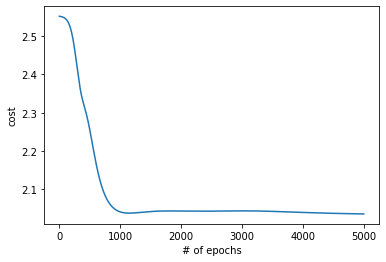

In [230]:
paras = skipgram_model_training(X, Y, vocab_size, 50, 0.05, 5000, batch_size=128, parameters=None, print_cost=True)